# Re-creating [Capillary Hysteresis in Neutrally Wettable Fibrous Media: A Pore Network Study of a Fuel Cell Electrode](http://link.springer.com/10.1007/s11242-017-0973-2)
# Part C: Purcell Meniscus Model

## Introduction

In the final part of this series we take a deeper look at the Purcell meniscus model, which is central to the whole study. The fundamental concept is that the fibers form throats with properties similar to that of a torus:

<img src="https://media.giphy.com/media/AIbz7mpqxgc5a/giphy.gif" style="width: 30%" align="center"/>

As the fluid invades throaugh the center of the torus the meniscus is pinned to the surface and the "effective" contact angle becomes influenced by the converging diverging geometry and is a function of the filling angle $\alpha$. The shape of the meniscus as the invading phase moves upwards through the torus with key model parameters is shown below.

<img src="https://i.imgur.com/b2der2w.png" style="width: 70%" align="center"/>

Different intrinsic contact angles through invading phase: (a) 60$^\circ$, (b) 90$^\circ$ and (c) 120$^\circ$. All scenarios clearly show an inflection of the meniscus curvature signifying a switch in the sign of the capillary pressure from negative to positive. This inflection is predicted to occur for all contact angles by the model with varying filling angle. The capillary pressure can be shown to be:

$P_C = -2\sigma cos(\theta-\alpha))/(r+R(1-cos(\alpha))$

## Set up
We will set up a trivially small network with one throat to demonstrate the use of the meniscus model. Here we do the imports and define a few functions for plotting.

In [1]:
import numpy as np
import sympy as syp
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 5)

theta = 90
fiberRad = 5e-6
throatRad = 2e-5
max_bulge = 1e-5

# Parameters for plotting fibers
x, R, rt, s, t = syp.symbols('x, R, rt, s, t')
points = np.linspace(-fiberRad, fiberRad, 1001)
y = R*syp.sqrt(1- (x/R)**2)
r = rt + (R-y)
rx = syp.lambdify((x, R, rt), r, 'numpy')

def plot_arc(ax, arc_cen, arc_rad, arc_angle, num_points=100):
    r'''
    plot the meniscus arc from neg to pos angle
    '''
    angles = np.linspace(-arc_angle, arc_angle, num_points)
    x = arc_cen - arc_rad*np.cos(angles)
    y = arc_rad*np.sin(angles)
    print(x)
    print(y)
    ax.plot(x, y, 'b-')

Populating the interactive namespace from numpy and matplotlib


Now we define our two pore network and add the meniscus model in several modes: 'max' returns the maximum pressure experienced by the meniscus as it transitions through the throat, i.e. the burst entry pressure. 'touch' is the pressure at which the meniscus has protruded past the throat center a distance defined by the 'touch_length' dictionary key. In network simulations this could be set to the pore_diameter. Finally the 'men' mode accepts a target_Pc parameter and returns all the mensicus information required for assessing cooperative filling or plotting.

In [2]:
import openpnm as op
import openpnm.models.physics as pm
net = op.network.Cubic(shape=[2, 1, 1], spacing=5e-5)
geo = op.geometry.StickAndBall(network=net,
                               pores=net.pores(),
                               throats=net.throats())
phase = op.phases.Water(network=net)
phase['pore.contact_angle'] = theta
phys = op.physics.Standard(network=net,
                           phase=phase,
                           geometry=geo)
geo['throat.diameter'] = throatRad*2
geo['throat.touch_length'] = max_bulge
phys.add_model(propname='throat.max',
               model=pm.meniscus.purcell,
               mode='max',
               r_toroid=fiberRad)
phys.add_model(propname='throat.touch',
               model=pm.meniscus.purcell,
               mode='touch',
               r_toroid=fiberRad)
phys.add_model(propname='throat.meniscus',
               model=pm.meniscus.purcell,
               mode='men',
               r_toroid=fiberRad,
               target_Pc=1000)
touch_Pc = phys['throat.touch'][0]
print(touch_Pc)
max_Pc = phys['throat.max'][0]
print(max_Pc)

4114.018827899374
5878.390833049412


We define a plotting function that uses the meniscus data:
$\alpha$ is filling angle as defined above,
$radius$ is the radius of curvature of the mensicus,
$center$ is the position of the centre of curvature relative to the throat center along the axis of the throat,
$\gamma$ is the angle between the throat axis and the line joining the meniscus center and meniscus contact point.

In [3]:
def plot_phys(target_Pc, print_data=False):
    phys.add_model(propname='throat.meniscus',
               model=pm.meniscus.purcell,
               mode='men',
               r_toroid=fiberRad,
               target_Pc=target_Pc)
    throatRad = geo['throat.diameter'][0]/2
    theta = np.deg2rad(phys['pore.contact_angle'][0])
    men_data = {}
    men_data['alpha'] = phys['throat.meniscus.alpha']
    men_data['gamma'] = phys['throat.meniscus.gamma']
    men_data['radius'] = phys['throat.meniscus.radius']
    men_data['center'] = phys['throat.meniscus.center']
    fig, ax = plt.subplots()
    ax.plot(points, rx(points, fiberRad, throatRad), 'k-')
    ax.plot(points, -rx(points, fiberRad, throatRad), 'k-')
    arc_cen = men_data['center']
    arc_rad = men_data['radius']
    arc_angle = men_data['gamma']
    angles = np.linspace(-arc_angle, arc_angle, 100)
    arcx = arc_cen - arc_rad*np.cos(angles)
    arcy = arc_rad*np.sin(angles)
    ax.plot(arcx, arcy, 'b-')
    ax.axis('equal')
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-6))
    if print_data:
        print(men_data)
    return ax

We can see that the touch_Pc calculated earlier, corresponds with the tip of the meniscus exceeding the max_bulge parameter. Try changing this and re-running to see what happens.

{'alpha': array([0.64350111]), 'gamma': array([0.64350111]), 'radius': array([3.5e-05]), 'center': array([-2.5e-05])}


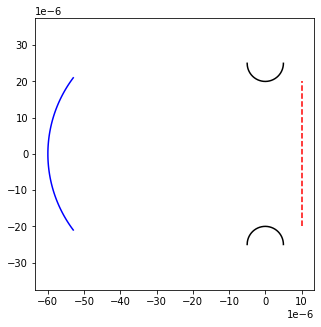

In [4]:
#NBVAL_IGNORE_OUTPUT
ax = plot_phys(target_Pc=touch_Pc, print_data=True);
ax.plot([max_bulge, max_bulge], [-throatRad, throatRad], 'r--');

We can interact with the mensicus model by changing the target_Pc parameter.

In [5]:
#NBVAL_IGNORE_OUTPUT
interact(plot_phys, target_Pc=(-max_Pc, max_Pc, 10));

interactive(children=(FloatSlider(value=-8.390833049412322, description='target_Pc', max=5878.390833049412, mi…